In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append(os.path.join('/Users/mosesadebayo/desktop/ats/repos/amanzi/src/physics/ats/tools/meshing/meshing_ats'))
try:
    import meshing_ats
except ImportError:
    sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing','meshing_ats'))
    import meshing_ats

In [17]:
import pandas as pd
p1=pd.read_csv('Stream_dem.txt', delimiter='\t')
p1=p1.sort_values(by="X", ascending=True)

In [18]:
#new_x=np.hstack((np.arange(0,101, 0.5),np.arange(102,305, 5)))
new_x=np.arange(0,9.4, 0.1)
new_y = np.interp(new_x, p1.X.values, p1['Graphic Profile 1'].values)

Text(0.5, 0, 'distance (m)')

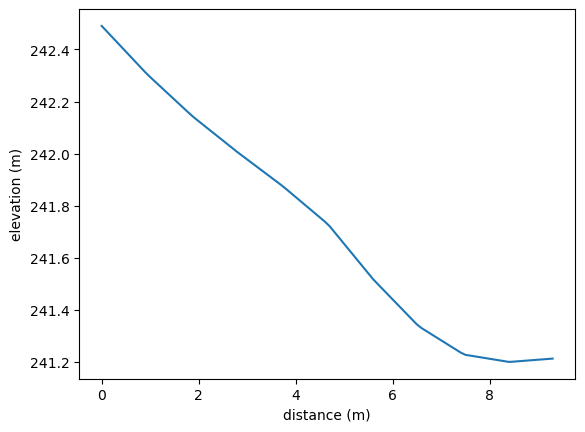

In [20]:
plt.plot(new_x,new_y)
#plt.plot(np.arange(0,11),[258.9]*11, 'k--',alpha=0.2)
#plt.plot(4.4,259.88,'o')
#plt.xlim(-1,10)
#plt.ylim(257,265)
plt.ylabel('elevation (m)')
plt.xlabel('distance (m)')

In [21]:
m2 = meshing_ats.Mesh2D.from_Transect(new_x,new_y,1)

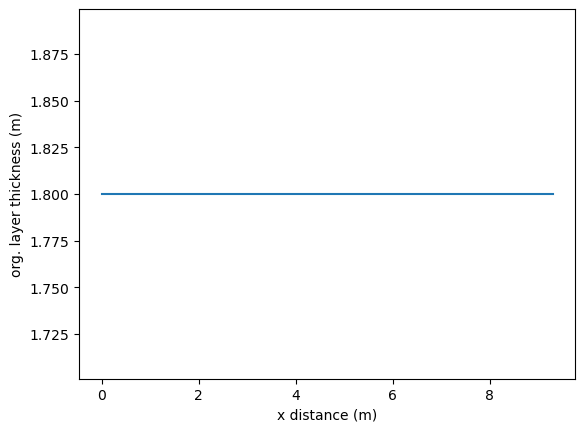

In [23]:
def organic_thickness1(x):
    """This function is the thickness of the layer we want to vary as a function of distance down the slope"""
    thickness = 1.8
    return thickness

layer_1 = np.array([organic_thickness1(xx) for xx in m2.coords])
plt.plot(new_x, layer_1[0:94]); plt.xlabel('x distance (m)'); plt.ylabel('org. layer thickness (m)');

In [25]:
# geometry of the transect extrusion
transect_layer_types = []
transect_layer_data = []
transect_layer_ncells = []

depth = []  # bookkeeping for material IDs
current_depth = 0

# We use the same dz as the above column, but because the material ID will change
# at a given depth in x, we spell it out with 1 cell per transect.
#
# 8 cells @ 0.5cm up to 4m mean thickness of first layer
dz = 0.05
depth.append(current_depth)
for i in range(40):
    transect_layer_types.append('constant')
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    depth.append(current_depth)
#increase slightly for the next 13m
dz = 0.3
while current_depth < 16:
    transect_layer_types.append("constant")
    transect_layer_data.append(dz)
    transect_layer_ncells.append(1)
    current_depth += dz
    dz=dz+0.5
    depth.append(current_depth)

# calculate the cell centroid depth
depth = np.array(depth)
transect_layer_depth = (depth[0:-1] + depth[1:])/2

# allocate 2D matrix for material id, (# surface cells, # layers)
n_layers = len(transect_layer_data)
transect_layer_mat_ids=np.zeros((n_layers, m2.num_cells()), 'i')
for j in range(m2.num_cells()):
    for i in range(n_layers):
        if (transect_layer_depth[i] <= layer_1[j]):
            transect_layer_mat_ids[i,j] = 1000
        else:
            transect_layer_mat_ids[i,j] = 100

# print out the layer information for the first column of cells
meshing_ats.summarize_extrusion(transect_layer_types, transect_layer_data, 
                                transect_layer_ncells, transect_layer_mat_ids, 0)





Cell summary:
------------------------------------------------------------
l_id	| c_id	|mat_id	| dz		| z_top
------------------------------------------------------------
 00 	| 00 	| 1000 	|   0.050000 	|   0.000000
 01 	| 01 	| 1000 	|   0.050000 	|   0.050000
 02 	| 02 	| 1000 	|   0.050000 	|   0.100000
 03 	| 03 	| 1000 	|   0.050000 	|   0.150000
 04 	| 04 	| 1000 	|   0.050000 	|   0.200000
 05 	| 05 	| 1000 	|   0.050000 	|   0.250000
 06 	| 06 	| 1000 	|   0.050000 	|   0.300000
 07 	| 07 	| 1000 	|   0.050000 	|   0.350000
 08 	| 08 	| 1000 	|   0.050000 	|   0.400000
 09 	| 09 	| 1000 	|   0.050000 	|   0.450000
 10 	| 10 	| 1000 	|   0.050000 	|   0.500000
 11 	| 11 	| 1000 	|   0.050000 	|   0.550000
 12 	| 12 	| 1000 	|   0.050000 	|   0.600000
 13 	| 13 	| 1000 	|   0.050000 	|   0.650000
 14 	| 14 	| 1000 	|   0.050000 	|   0.700000
 15 	| 15 	| 1000 	|   0.050000 	|   0.750000
 16 	| 16 	| 1000 	|   0.050000 	|   0.800000
 17 	| 17 	| 1000 	|   0.050000 	|   0.850000
 1

In [26]:
# make the mesh, save it as an exodus file
m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, transect_layer_types,transect_layer_data, 
                                        transect_layer_ncells, transect_layer_mat_ids)
if os.path.exists('Site_1.exo'):
    os.remove('Site_1.exo')
m3.write_exodus('Site_1.exo')


You are using exodus.py v 1.21.2 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013-2023 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: Site_1.exo
Closing exodus file: Site_1.exo


In [27]:
os.system("/Users/mosesadebayo/desktop/ats/amanzi_tpls-install-master-Debug/bin/meshconvert Site_1.exo Site_1_view.exo")


App to convert unstructured meshes between formats
Contact: Rao Garimella (rao@lanl.gov)

Importing mesh from ExodusII file...Building classification information....Done
Exporting mesh to ExodusII/NemesisI format...Done


0